In [9]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib.colors import ListedColormap
from IPython.display import Markdown as md
from IPython.display import HTML, display
from collections import Counter
import math

%matplotlib inline

pd.options.display.float_format = '{:.0f}'.format

In [10]:
df = pd.read_csv('../output/input.csv')



Emergency hospitalisations

In [11]:
num_patients = len(df['patient_id'].unique())
num_patients_hosp = len(df[df['hospital_admission'].notna()]['patient_id'].unique())
num_patients_hosp_prim_covid = len(df[df['primary_covid_hospital_admission'].notna()]['patient_id'].unique())
num_patients_hosp_covid = len(df[df['covid_hospital_admission'].notna()]['patient_id'].unique())

In [12]:
display(HTML(f'<table><tr><th>Emergency Hospital Admission</th></tr><tr><th>Group</th><th>Total</th><th>%</th></tr><tr><td>Emergency Admission</td><td>{num_patients_hosp}</td><td>-</td></tr><tr><td>Emergency Admission with Primary Covid</td><td>{num_patients_hosp_prim_covid}</td><td>{(num_patients_hosp_prim_covid/num_patients_hosp)*100:.2f}%</td></tr><tr><td>Emergency Admission</td><td>{num_patients_hosp_covid}</td><td>{(num_patients_hosp_covid/num_patients_hosp)*100:.2f}%</td></tr></table>'
))

Emergency hospitalisations with primary covid

In [17]:
num_patients_attended_ae = len(df[(df['primary_covid_hospital_admission'].notna() & df['ae_attendance_no_discharge']==1)]['patient_id'].unique())
num_patients_attended_ae_with_discharge = len(df[(df['primary_covid_hospital_admission'].notna() & df['discharge_destination'].notna())]['patient_id'].unique())
num_patients_attended_ae_cov = len(df[(df['primary_covid_hospital_admission'].notna() & df['ae_attendance_covid_status']==1)]['patient_id'].unique())
num_patients_attended_ae_resp = len(df[(df['primary_covid_hospital_admission'].notna() & df['ae_attendance_respiratory_status']==1)]['patient_id'].unique())
num_patients_attended_ae_cov_pc = len(df[(df['primary_covid_hospital_admission'].notna() & df['covid_primary_care_before_ae_attendance']==1)]['patient_id'].unique())
num_patients_attended_ae_pos_test = len(df[(df['primary_covid_hospital_admission'].notna() & df['positive_covid_test_before_ae_attendance']==1)]['patient_id'].unique())
num_patients_attended_ae_pos_test_month = len(df[(df['primary_covid_hospital_admission'].notna() & df['positive_covid_test_month_before_ae_attendance']==1)]['patient_id'].unique())

In [18]:
display(HTML(f'<table><tr><th>Emergency Hospitalisation with primary Covid-19</th></tr><tr><th>Group</th><th>Total</th><th>%</th></tr><tr><td>Attended A&E</td><td>{num_patients_attended_ae}</td><td>{(num_patients_attended_ae/num_patients_hosp_prim_covid)*100:.2f}%</td></tr><tr><td>Attended A&E with discharge info</td><td>{num_patients_attended_ae_with_discharge}</td><td>{(num_patients_attended_ae_with_discharge/num_patients_hosp_prim_covid)*100:.2f}%</td></tr><tr><td>Attended A&E with COVID-19 diagnosis code</td><td>{num_patients_attended_ae_cov}</td><td>{(num_patients_attended_ae_cov/num_patients_hosp_prim_covid)*100:.2f}%</td></tr><tr><td>Attended A&E with respiratory-related diagnosis code</td><td>{num_patients_attended_ae_resp}</td><td>{(num_patients_attended_ae_resp/num_patients_hosp_prim_covid)*100:.2f}%</td></tr><tr><td>Attended A&E with recent COVID-19 in PC</td><td>{num_patients_attended_ae_cov_pc}</td><td>{(num_patients_attended_ae_cov_pc/num_patients_hosp_prim_covid)*100:.2f}%</td></tr><tr><td>Attended A&E with positive test in previous 2 weeks</td><td>{num_patients_attended_ae_pos_test}</td><td>{(num_patients_attended_ae_pos_test/num_patients_hosp_prim_covid)*100:.2f}%</td></tr><tr><td>Attended A&E with positive test in previous month</td><td>{num_patients_attended_ae_pos_test_month}</td><td>{(num_patients_attended_ae_pos_test_month/num_patients_hosp_prim_covid)*100:.2f}%</td></tr></table>'))


Discharge destination in patients with primary covid hospitalisation who previously attended A&E.

In [30]:
prim_cov_ae_discharge = df[(df['primary_covid_hospital_admission'].notna() & df['ae_attendance_no_discharge']==1)]['discharge_destination']
missing = prim_cov_ae_discharge.isna().sum()
destination_dict = Counter(prim_cov_ae_discharge[prim_cov_ae_discharge.notnull()])
destination_dict['missing'] = missing

discharge_dict = {1066341000000100:"Ambulatory Emergency Care", 19712007: "Patient Transfer", 183919006: "Other", 1066361000000104: "High dependency unit", 305398007: "Mortuary", 1066381000000108: "Other", 1066331000000109: "Emergency department short stay ward", 306705005: "Other", 306706006:"Ward", 306689006: "Home", 306694006: "Residential or Nursing Home", 306691003: "Residential or Nursing Home", 1066351000000102: "Other", 1066401000000108: "Other", 1066371000000106: "Coronary Care Unit", 50861005: "Other", 1066391000000105: "ICU", "missing": "missing"}
percent_dict = {}
data = []
total = 0

for key, value in destination_dict.items():
    total+=value

for key, value in destination_dict.items():
    percent = (value/total) * 100
    row = [discharge_dict[key], value, percent]
    data.append(row)

discharge_destination_df = pd.DataFrame(data, columns=["Discharge Destination", "Number", "%"])
discharge_destination_df


,Discharge Destination,Number,%
0,Ward,228,20
1,ICU,263,23
2,missing,665,58


Define models

In [31]:
positive_covid_patients_sus = df[df['primary_covid_hospital_admission'].notna()]
negative_covid_patients_sus = df[~df['primary_covid_hospital_admission'].notna()]

In [32]:
#model_a

positive_covid_patients_a = df[(df['ae_attendance_any']==1) & ((df['ae_attendance_covid_status']==1) | (df['positive_covid_test_before_ae_attendance'] ==1) | (df['covid_primary_care_before_ae_attendance'] ==1))]
negative_covid_patients_a = df[(df['ae_attendance_any']==0) | ((df['ae_attendance_any']==1) & ((df['ae_attendance_covid_status']==0) & (df['positive_covid_test_before_ae_attendance'] ==0) & (df['covid_primary_care_before_ae_attendance'] ==0)))]


sus_patients_positive = set(list(positive_covid_patients_sus['patient_id']))
model_a_patients_positive = set(list(positive_covid_patients_a['patient_id']))

sus_patients_negative = set(list(negative_covid_patients_sus['patient_id']))
model_a_patients_negative = set(list(negative_covid_patients_a['patient_id']))


sus_pos_ecds_pos = len(list(set(sus_patients_positive) & set(model_a_patients_positive)))
sus_pos_ecds_neg = len(list(set(sus_patients_positive) & set(model_a_patients_negative)))
sus_neg_ecds_pos = len(list(set(sus_patients_negative) & set(model_a_patients_positive)))
sus_neg_ecds_neg = len(list(set(sus_patients_negative) & set(model_a_patients_negative)))

In [39]:
sensitivity_a = (sus_pos_ecds_pos/(sus_pos_ecds_pos + sus_pos_ecds_neg))*100
specificity_a = (sus_neg_ecds_neg/(sus_neg_ecds_pos + sus_neg_ecds_neg))*100
PPV_a = (sus_pos_ecds_pos/(sus_pos_ecds_pos + sus_neg_ecds_pos))*100
NPV_a = (sus_neg_ecds_neg/(sus_neg_ecds_neg + sus_pos_ecds_neg))*100
MCC_a = ((sus_pos_ecds_pos * sus_neg_ecds_neg)-(sus_neg_ecds_pos * sus_pos_ecds_neg))/math.sqrt((sus_pos_ecds_pos + sus_neg_ecds_pos)*(sus_pos_ecds_neg+sus_neg_ecds_neg)*(sus_pos_ecds_pos + sus_pos_ecds_neg)*(sus_neg_ecds_pos+sus_neg_ecds_neg))


In [40]:
#model_b

positive_covid_patients_b = df[(df['ae_attendance']==1) & ((df['ae_attendance_covid_status']==1) | (df['positive_covid_test_before_ae_attendance'] ==1) | (df['covid_primary_care_before_ae_attendance'] ==1))]
negative_covid_patients_b = df[(df['ae_attendance']==0) | ((df['ae_attendance']==1) & ((df['ae_attendance_covid_status']==0) & (df['positive_covid_test_before_ae_attendance'] ==0) & (df['covid_primary_care_before_ae_attendance'] ==0)))]


sus_patients_positive = set(list(positive_covid_patients_sus['patient_id']))
model_b_patients_positive = set(list(positive_covid_patients_b['patient_id']))

sus_patients_negative = set(list(negative_covid_patients_sus['patient_id']))
model_b_patients_negative = set(list(negative_covid_patients_b['patient_id']))


sus_pos_ecds_pos = len(list(set(sus_patients_positive) & set(model_b_patients_positive)))
sus_pos_ecds_neg = len(list(set(sus_patients_positive) & set(model_b_patients_negative)))
sus_neg_ecds_pos = len(list(set(sus_patients_negative) & set(model_b_patients_positive)))
sus_neg_ecds_neg = len(list(set(sus_patients_negative) & set(model_b_patients_negative)))

In [41]:
sensitivity_b = (sus_pos_ecds_pos/(sus_pos_ecds_pos + sus_pos_ecds_neg))*100
specificity_b = (sus_neg_ecds_neg/(sus_neg_ecds_pos + sus_neg_ecds_neg))*100
PPV_b = (sus_pos_ecds_pos/(sus_pos_ecds_pos + sus_neg_ecds_pos))*100
NPV_b = (sus_neg_ecds_neg/(sus_neg_ecds_neg + sus_pos_ecds_neg))*100
MCC_b = ((sus_pos_ecds_pos * sus_neg_ecds_neg)-(sus_neg_ecds_pos * sus_pos_ecds_neg))/math.sqrt((sus_pos_ecds_pos + sus_neg_ecds_pos)*(sus_pos_ecds_neg+sus_neg_ecds_neg)*(sus_pos_ecds_pos + sus_pos_ecds_neg)*(sus_neg_ecds_pos+sus_neg_ecds_neg))


In [42]:
#model_c

positive_covid_patients_c = df[(df['ae_attendance']==1) & ((df['ae_attendance_covid_status']==1) | (df['ae_attendance_respiratory_status']==1) | (df['positive_covid_test_before_ae_attendance'] ==1) | (df['covid_primary_care_before_ae_attendance'] ==1))]
negative_covid_patients_c = df[(df['ae_attendance']==0) | ((df['ae_attendance']==1) & ((df['ae_attendance_covid_status']==0) & (df['ae_attendance_respiratory_status']==1) & (df['positive_covid_test_before_ae_attendance'] ==0) & (df['covid_primary_care_before_ae_attendance'] ==0)))]


sus_patients_positive = set(list(positive_covid_patients_sus['patient_id']))
model_c_patients_positive = set(list(positive_covid_patients_c['patient_id']))

sus_patients_negative = set(list(negative_covid_patients_sus['patient_id']))
model_c_patients_negative = set(list(negative_covid_patients_c['patient_id']))


sus_pos_ecds_pos = len(list(set(sus_patients_positive) & set(model_c_patients_positive)))
sus_pos_ecds_neg = len(list(set(sus_patients_positive) & set(model_c_patients_negative)))
sus_neg_ecds_pos = len(list(set(sus_patients_negative) & set(model_c_patients_positive)))
sus_neg_ecds_neg = len(list(set(sus_patients_negative) & set(model_c_patients_negative)))

In [43]:
sensitivity_c = (sus_pos_ecds_pos/(sus_pos_ecds_pos + sus_pos_ecds_neg))*100
specificity_c = (sus_neg_ecds_neg/(sus_neg_ecds_pos + sus_neg_ecds_neg))*100
PPV_c = (sus_pos_ecds_pos/(sus_pos_ecds_pos + sus_neg_ecds_pos))*100
NPV_c = (sus_neg_ecds_neg/(sus_neg_ecds_neg + sus_pos_ecds_neg))*100
MCC_c = ((sus_pos_ecds_pos * sus_neg_ecds_neg)-(sus_neg_ecds_pos * sus_pos_ecds_neg))/math.sqrt((sus_pos_ecds_pos + sus_neg_ecds_pos)*(sus_pos_ecds_neg+sus_neg_ecds_neg)*(sus_pos_ecds_pos + sus_pos_ecds_neg)*(sus_neg_ecds_pos+sus_neg_ecds_neg))


In [45]:
display(HTML(f'<table><tr><th>Model</th><th>Sensitivity</th><th>Specificity</th><th>PPV</th><th>NPV</th><th>MCC</th></tr><td>A</td><td>{sensitivity_a}</td><td>{specificity_a}</td><td>{PPV_a}</td><td>{NPV_a}</td><td>{MCC_a}</td><tr><td>B</td><td>{sensitivity_b}</td><td>{specificity_b}</td><td>{PPV_b}</td><td>{NPV_b}</td><td>{MCC_b}</td></tr><tr><td>C</td><td>{sensitivity_c}</td><td>{specificity_c}</td><td>{PPV_c}</td><td>{NPV_c}</td><td>{MCC_c}</td></tr></table>'))


<AxesSubplot:>

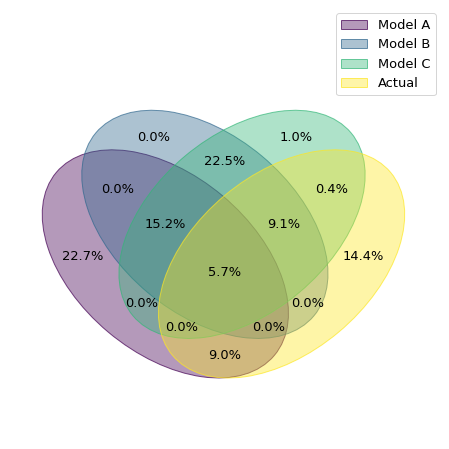

In [53]:
# from venn import venn

# data = {"Model A": model_a_patients_positive, "Model B": model_b_patients_positive, "Model C": model_c_patients_positive, "Actual":sus_patients_positive}
# venn(data, fmt="{percentage:.1f}%")